## Some data exploration

In [1]:
# import statements 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

quick look at the Sambanis dataset

In [2]:
# 88 variables specified in Sambanis 2006, found in R code
cols_sambanis = ["warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
        "autonomy", "avgnabo", "centpol3", "cowcode", "coldwar", "decade1", "decade2",
        "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel",
        "durable", "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590",
        "expgdp", "exrec", "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2",
        "geo34", "geo57", "geo69", "geo8", "illiteracy", "incumb", "infant",
        "inst", "inst3", "life", "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper",
        "mirps0", "mirps1", "mirps2", "mirps3", "nat_war", "ncontig",
        "nmgdp", "nmdp4_alt", "numlang", "nwstate", "oil", "p4mchg",
        "parcomp", "parreg", "part", "partfree", "plural", "plurrel",
        "pol4", "pol4m", "pol4sq", "polch98", "polcomp", "popdense",
        "presi", "pri", "proxregc", "ptime", "reg", "regd4_alt", "relfrac", "seceduc",
        "second", "semipol3", "sip2", "sxpnew", "sxpsq", "tnatwar", "trade",
        "warhist", "xconst", "year"]

sambanis = pd.read_csv("SambnisImp.csv", usecols=cols_sambanis)

#keep only the year value for date (drop 1-january, dummy)
#sambanis["year"] = pd.DatetimeIndex(sambanis["year"]).year


### Print informations
print(f'Sambanis dataset has {sambanis.shape[0]} rows with {sambanis.shape[1]} features.')
#civil_war contains only the observations with a civil war
civil_war = sambanis[sambanis["warstds"]==1]
print(f'There are {civil_war.shape[0]} civil war in the dataset.')
nb_country_cw = len(civil_war['cowcode'].value_counts())
print(f'There are {nb_country_cw} different country which had a CW (some countries had multiple CW)')
print(f'The data ranges from 1945 to 2000. The first CW dates form {min(civil_war.year)} and the last {max(civil_war.year)}')

Sambanis dataset has 7140 rows with 93 features.
There are 116 civil war in the dataset.
There are 72 different country which had a CW (some countries had multiple CW)
The data ranges from 1945 to 2000. The first CW dates form 1946 and the last 1999


In [3]:
var2label_s = dict({
    "sxpsq":"Primary Commodity Exports (Squared)",
    "sxpnew":"Primary Commodity Exports",
    "agexp":"Agricultural Raw Materials Exports",
    "illiteracy":"Illiteracy Rate",
    "manuexp":"Manufactures Exports",
    "milper":"Military Power",
    "fuelexp":"Fuel and Oil Exports",
    "gdpgrowth":"GDP Growth",
    "lpopns": "Population (logged)",
    "trade":"Trade as Percent of GDP",
    "expgdp":"Goods & Services Exports",
    "nmgdp":"Neighbors' average GDP per capita)",
    "popdense":"Population Density",
    "ln_gdpen":"GDP per Capita (logged)",
    "ptime":"ptime = ???",
    "avgnabo":"Average SUP score of neighbors",
    "pri":"Primary Education",
    "ager":"Goverment age",
    "infant":"Infant mortality",
    "durable":"Year since last regime transition",
    "life":"Life Expectancy",
    "seceduc":"Secondary Education",
    "dlang":"Linguistic Hetrogeneity",
    "partfree":"Anocracy",
    "part":"ln(Share of population voting x opposition's share \
of votes cast)",
    "p4mchg":"Annual change in modified polity, Polity IV",
    "demch98":"Democracy annual change; Polity 98",
    "dem":"Democracy",
    "incumb":"Consolidation of incumbent advantages (Przeworksi \
et al., 2000)",
    "army85":"Military Power",
    "major":"Majoritatian system",
    "semipol3": "Semi-federal state, Polity III",
    "oil":"Oil Exports per GDP",
    "lmtnest":"Rough Terrain",
    "autonomy":"Country has de facto autonomous regions",
    "sip2":"Continuous measure of democracy",
    "ehet":"Ethnic Heterogeneity",
    "ef":"Ethnic Fractionalization",
    "regd4_alt":"Median Regional Polity Score",
    "pol4sq":"Polity Index squarred",
    "presi":"Presidential system",
    "proxregc":"Regime Transition Score",
    "inst3":"Political Instability",
    "xconst":"Executive constraints - operational independence of CE",  
})

quick look at trade_reg.csv. created from Trade-Register-1950-2000.txt

In [4]:
trade = pd.read_csv("trade_reg.csv",sep='\t')

In [5]:
print(f'The data ranges from {min(trade.year_order)} to {max(trade.year_order)}.')
#number of transaction
trade.supplier.value_counts()[:15]

The data ranges from (1940) to 2000.


United States          6226
Soviet Union           3358
France                 1854
United Kingdom         1689
Germany                 706
Italy                   576
China                   433
Russia                  351
Canada                  326
Netherlands             324
Sweden                  216
Israel                  215
Switzerland             209
Unknown supplier(s)     141
Ukraine                 110
Name: supplier, dtype: int64

In [6]:
#number of transaction
trade.recipient.value_counts()[:15]

Egypt          433
India          427
Turkey         409
Greece         407
Thailand       382
Israel         314
South Korea    313
Spain          299
Argentina      298
Taiwan         297
Pakistan       290
Iran           289
Indonesia      284
Iraq           284
Japan          284
Name: recipient, dtype: int64

Adding the "country" column in sambanis dataset based on the cowcodes

In [7]:
#loading the cowcode dataset
cowcodes = pd.read_csv("COW_country_codes.csv")
cowcodes = cowcodes.rename(columns={'CCode': 'cowcode', 'StateNme':'country'})
#create the dictionaries
dict_cowcode = dict(zip(cowcodes.cowcode,cowcodes.country))
dict_cowcode_abb = dict(zip(cowcodes.cowcode,cowcodes.StateAbb))

sambanis['country'] = sambanis.cowcode.map(dict_cowcode)
sambanis['country_abb'] =sambanis.cowcode.map(dict_cowcode_abb) 
#don't know if it is necessary to add the abbreviation but I figured it could be useful

Counting how many countries who had a civil war were also the recipient of weapons within a time range

In [8]:
trade.year_order = trade.year_order.str.strip('( )') 
#j'ai juste enlevé les parenthèse mais je sais pas si on devrait garder ces lignes ou pas
#trade.recipient = trade.recipient.str.strip(' ')

#transform to datetime
sambanis['year'] = pd.to_datetime(sambanis['year'],format='%Y')
trade['year_order'] = pd.to_datetime(trade['year_order'],format='%Y')

In [9]:
civil_war = sambanis[sambanis["warstds"]==1]
civil_war['import_weapons'] = 0

<ipython-input-9-7ab86b3c87f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  civil_war['import_weapons'] = 0


In [10]:
for id in civil_war.index:
    country = civil_war.country.loc[id]
    date = civil_war.year.loc[id]
    start = date + dt.timedelta(days=-365) # 3 years, to be changed?
    end = date + dt.timedelta(days=365)
    mask = (trade['year_order'] >= start) & (trade['year_order'] <= end)
    trade_tmp = trade.loc[mask]
    if (trade_tmp.recipient.str.contains(country).sum()>0):
        civil_war.loc[id,'import_weapons'] = 1

/home/toinou/Documents/venvs/pyt3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [11]:
#number of civil war "accompagnied" by weaponery transactions
civil_war['import_weapons'].sum() 

82

In [12]:
def plot_feat(df, country, feat, var2label=var2label_s,
              ax=None, title=None):
    tmp=df.loc[df["country"]==country]
    if ax != None:
        ax.scatter(tmp.year, tmp[feat])
        for onset in tmp.loc[tmp["warstds"] == 1]["year"]:
            ax.axvline(x=onset, c='r')
        ax.set_title(title)
    else:
        plt.scatter(tmp.year, tmp[feat])
        for onset in tmp.loc[tmp["warstds"] == 1]["year"]:
            plt.axvline(x=onset, c='r')
        plt.title(var2label[feat])
        plt.show()

In [13]:
#"high importance features" ~ (cf Random Forest)
feat_subset = [ "sxpnew",
                "illiteracy",
                "milper",
                "gdpgrowth",
                "lpopns",
                "pri",
                "infant",
                "life",
                "seceduc"
              ]

#list of countries affected by at least 1 CW
CW_countries = list(sambanis.loc[sambanis["warstds"]==1]["country"].drop_duplicates())

In [14]:
#ploting of features accross all the countries
"""
#iterate on the "high priority features"
for key in feat_subset:
    #create enough column and row for 
    fig, ax = plt.subplots(nrows=9, ncols=9, figsize=(50,50))
    j=0
    #iterate on the countries affected by civil war
    for i, country in enumerate(CW_countries):
        if i%9 == 0 and i != 0:
            j+=1
        plot_feat(sambanis, country, key, ax=ax[j,i%9], title=country)
    
    #save plot as pdf to enable lossless zooming using pdf viewer
    fig.savefig(fname="fig_"+var2label_s[key]+".pdf", format="pdf")
"""

'\n#iterate on the "high priority features"\nfor key in feat_subset:\n    #create enough column and row for \n    fig, ax = plt.subplots(nrows=9, ncols=9, figsize=(50,50))\n    j=0\n    #iterate on the countries affected by civil war\n    for i, country in enumerate(CW_countries):\n        if i%9 == 0 and i != 0:\n            j+=1\n        plot_feat(sambanis, country, key, ax=ax[j,i%9], title=country)\n    \n    #save plot as pdf to enable lossless zooming using pdf viewer\n    fig.savefig(fname="fig_"+var2label_s[key]+".pdf", format="pdf")\n'

### Antoine observations
- GDP Growth : for several countries, the onset of CW is followed by a brutal drop (expected based on the replication work with Random Forest), it sometimes even becomes negative.
- Illiteracy (adult): hard to tell, it seems to decrease with time overall, did not notice brutal spike (somehow logic; people don't forget how to read because of civil war. maybe try to detect delayed effect?)
- Infant Mortality : definitely something, the onset are often associated with a big jump (ponctual)
- Life Expectancy : super obvious, on CW onset year, the value is usually much lower
- Military power : interesting as well, some "jump to a new plateau" can be observed (Vietnam for exemple) or just ponctual spike.
- Population (logged) : Nothing visible except for Laos
- Primary Commodity Export : sudden drop visible for african countries (Sierra Leone, Somalia, South Africa, Uganda, ..). Not visible for every single onset.
- Primary Education : ponctual drop on onset year
- Secondary Education : same as Primary. (Cuba seems interesting)

In [15]:
#load the border dataset
geodata = pd.read_csv("geodata.csv")

In [16]:
def comp_neighbour_feat(df, country, geodata=geodata):
    tmp = list(geodata.loc[geodata["country_name"] == country]["country_border_name"])
    neigh_df = df.loc[df["country"].isin(tmp)]
    return neigh_df

In [17]:
cowcodes.loc[cowcodes["country"] == "Afghanistan"]

,StateAbb,cowcode,country
196,AFG,700,Afghanistan


In [18]:
geodata.loc[geodata["country_name"]=="Afghanistan"]

,country_code,country_name,country_border_code,country_border_name
4,AF,Afghanistan,CN,China
5,AF,Afghanistan,IR,Iran (Islamic Republic of)
6,AF,Afghanistan,PK,Pakistan
7,AF,Afghanistan,TJ,Tajikistan
8,AF,Afghanistan,TM,Turkmenistan
9,AF,Afghanistan,UZ,Uzbekistan


In [19]:
#return the values associated with the neighbouring countries
#very practical to compute any kind of stats on them!
comp_neighbour_feat(sambanis, "Afghanistan")

,cowcode,year,warstds,ptime,autonomy,popdense,army85,milper,trade,nmgdp,...,mirps3,sxpsq,pol4sq,decade1,decade2,decade3,decade4,proxregc,country,country_abb
1246,710,1945-01-01,0,12,0.005858,116.966856,157819.9204,151.709933,71.578024,4527.962959,...,0.376234,0.050435,61.385113,0,0,0,0,0.146336,China,CHN
1247,710,1946-01-01,0,24,0.000000,100.706551,181078.2145,132.386317,47.379103,3223.125632,...,0.261949,0.022304,46.854656,0,0,0,0,1.000000,China,CHN
1248,710,1947-01-01,1,30,0.000000,102.028569,181950.8091,133.119056,47.270288,3235.100446,...,0.000000,0.022267,25.000000,0,0,0,0,1.000000,China,CHN
1249,710,1948-01-01,0,42,0.000000,104.708751,210077.2142,173.845392,57.672336,3691.509690,...,0.000000,0.031597,25.000000,0,0,0,0,1.000000,China,CHN
1250,710,1949-01-01,0,54,0.000000,100.279922,194740.3814,147.342853,47.668467,3249.816226,...,0.000000,0.021977,25.000000,0,0,0,0,1.000000,China,CHN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6741,704,1996-01-01,0,72,0.000000,119.133533,130072.9965,121.858694,73.004614,4495.004001,...,0.000000,0.052840,81.000000,0,0,0,0,0.003906,Uzbekistan,UZB
6742,704,1997-01-01,0,84,0.000000,119.948176,130413.3279,121.881064,73.063804,4496.395029,...,0.000000,0.052816,81.000000,0,0,0,0,0.000977,Uzbekistan,UZB
6743,704,1998-01-01,0,96,0.000000,118.667912,130582.6211,121.031052,72.771353,4517.247506,...,0.000000,0.052625,81.000000,0,0,0,0,0.000244,Uzbekistan,UZB
6744,704,1999-01-01,0,108,0.000000,118.815052,130309.0554,120.613178,72.799310,4515.555689,...,0.000000,0.052727,81.000000,0,0,0,0,0.000061,Uzbekistan,UZB


In [20]:
comp_neighbour_feat(sambanis, "Lao People's Democratic Republic")["country"].drop_duplicates()
#comp_neighbour_feat(sambanis, "Thailand")["country"].drop_duplicates()

937     Cambodia
1246       China
4339     Myanmar
6186    Thailand
Name: country, dtype: object

In [21]:
# correct the name of the country to facilitate the merge betwen sambanis and geodata
dic_country_conv = dict({
    "Bolivia (Plurinational State Of)":"Bolivia",
    'Cabo Verde':'Cape Verde',
    'Czechia':'Czech Republic',
    'Congo (the Democratic Republic of the)':'Democratic Republic of the Congo',
    'Gambia (the)':'Gambia',
    'Iran (Islamic Republic of)':'Iran',
    'Cote d’Ivoire':'Ivory Coast',
    "Lao People's Democratic Republic":'Laos',
    "Moldova (the Republic of)":'Moldova',
    'Viet Nam':'Republic of Vietnam',
    'Russian Federation':'Russia',
    'Korea (the Republic of)':'South Korea',
    'Eswatini':'Swaziland',
    'Syrian Arab Republic':'Syria',
    'Taiwan (Province of China)':'Taiwan',
    'Tanzania (the United Republic of)':'Tanzania',
    'United Kingdom of Great Britain and Northern Ireland':'United Kingdom',
    'Venezuela (Bolivarian Republic of)':'Venezuela',
    
    "Yemen People's Republic":'Yemen',
    'Yemen Arab Republic':'Yemen',
    '???':'Czechoslovakia',
    "???":'Yugoslavia',
    "???":'Zanzibar',
    "???":'Kosovo',
    "???":'Macedonia'
})
#left a space between the countries that required manual handling

#update the name of the countries in the geodata to allow a merge
geodata["country_name"].replace(to_replace=dic_country_conv, inplace=True)
geodata["country_border_name"].replace(to_replace=dic_country_conv, inplace=True)

In [22]:
print("Laos")
print(list(comp_neighbour_feat(sambanis, "Laos")["country"].drop_duplicates()))
print("Thailand")
print(list(comp_neighbour_feat(sambanis, "Thailand")["country"].drop_duplicates()))

Laos
['Cambodia', 'China', 'Myanmar', 'Thailand', 'Republic of Vietnam']
Thailand
['Cambodia', 'Laos', 'Malaysia', 'Myanmar']


In [23]:
# countries experiencing civil war for which we don't have borders informations
set(CW_countries)-set(geodata["country_name"])

{'Kosovo', 'Yemen Arab Republic', "Yemen People's Republic"}

In [24]:
#countries from sambanis for which we don't have geodata (potential neighbours)
set(sambanis["country"])-set(geodata["country_name"])

{'Czechoslovakia',
 'German Federal Republic',
 'Kosovo',
 'Macedonia',
 'Yemen Arab Republic',
 "Yemen People's Republic",
 'Yugoslavia',
 'Zanzibar',
 nan}

In [25]:
df_tiv_import = pd.read_csv("TIV-Import-All-1950-2019.csv")
df_tiv_export = pd.read_csv("TIV-Export-All-1950-2019.csv")
df_tiv_import.drop(columns=["Total"], inplace=True)
df_tiv_export.drop(columns=["Total"], inplace=True)

In [26]:
#update the country name conversion dictionnary
dic_country_conv.update({
    'Bosnia-Herzegovina':'Bosnia and Herzegovina',
    'Cabo Verde':'Cape Verde',
    'Viet Nam':'Republic of Vietnam',
    'UAE':'United Arab Emirates',
    'United States':'United States of America',
    'South Yemen':"Yemen People's Republic",
    'North Yemen':'Yemen Arab Republic',
    'DR Congo':'Democratic Republic of the Congo',
    "Cote d'Ivoire":'Ivory Coast'
})

#update the TIV import
df_tiv_import["country"].replace(to_replace=dic_country_conv, inplace=True)

#update the TIV export
df_tiv_export["country"].replace(to_replace=dic_country_conv, inplace=True)

In [27]:
#countries from samabanis for which we don't have entries in tiv table
set(sambanis["country"]) - \
                set(sambanis["country"]
                   ).intersection(
                set(df_tiv_import["country"]))

#German Federal Republic : West Gemarny, doesn't exist in TIV tables
#Zanzibar : semi-autonomous region in Tanzania

{'German Federal Republic', 'Zanzibar', nan}

In [28]:
#CELL ABOVE MUST BE ADAPTED FOR THE EXPORT BUT MORE COMPLEX BECAUSE
#IT'S POSSIBLE THAT SOME COUNTRIES DO NOT EXPORT WEAPONS.

In [29]:
#list of entities in TIV tables that aren't associated to a country
#from sambanis. A lot of them are rebel groups (potential actors of
#the civil war)
set(df_tiv_import["country"]) - \
                set(sambanis["country"]
                    ).intersection(
                set(df_tiv_import["country"]))

{'ANC (South Africa)*',
 'African Union**',
 'Amal (Lebanon)*',
 'Anti-Castro rebels (Cuba)*',
 'Armas (Guatemala)*',
 'Biafra',
 'Brunei',
 'Contras (Nicaragua)*',
 'Darfur rebels (Sudan)*',
 'ELF (Ethiopia)*',
 'EPLF (Ethiopia)*',
 'East Germany (GDR)',
 'Equatorial Guinea',
 'FAN (Chad)*',
 'FMLN (El Salvador)*',
 'FNLA (Angola)*',
 'FRELIMO (Portugal)*',
 'GUNT (Chad)*',
 'Haiti rebels*',
 'Hamas (Palestine)*',
 'Hezbollah (Lebanon)*',
 'Houthi rebels (Yemen)*',
 'Indonesia rebels*',
 'Katanga',
 'Khmer Rouge (Cambodia)*',
 'Kiribati',
 'LF (Lebanon)*',
 'LRA (Uganda)*',
 'LTTE (Sri Lanka)*',
 'Lebanon Palestinian rebels*',
 'Libya GNC',
 'Libya HoR',
 'MNLF (Philippines)*',
 'MPLA (Portugal)*',
 'MTA (Myanmar)*',
 'Madagascar',
 'Maldives',
 'Marshall Islands',
 'Micronesia',
 'Montenegro',
 'Mujahedin (Afghanistan)*',
 'NATO**',
 'NLA (Macedonia)*',
 'NTC (Libya)*',
 'North Korea',
 'Northern Alliance (Afghanistan)*',
 'Northern Cyprus',
 'OSCE**',
 'PAIGC (Portugal)*',
 'PIJ (Is

In [30]:
#list of entities in TIV tables that aren't associated to a country
#from sambanis. Contains rebel group, old countries and NGO
set(df_tiv_export["country"]) - set(sambanis["country"]).intersection(set(df_tiv_export["country"]))

{'Aruba',
 'Brunei',
 'East Germany (GDR)',
 'European Union**',
 'FMLN (El Salvador)*',
 'Libya HoR',
 'Montenegro',
 'Mujahedin (Afghanistan)*',
 'North Korea',
 'Serbia',
 'South Vietnam',
 'Soviet Union',
 'United Nations**',
 'Unknown supplier(s)'}

In [31]:
# melt the TIV df to enable merging on country and year columns
tiv_imp_m = pd.melt(df_tiv_import,
                    id_vars="country",
                    var_name="year",
                    value_name="tiv_imp")
tiv_exp_m = pd.melt(df_tiv_export,
                    id_vars="country",
                    var_name="year",
                    value_name="tiv_exp")

#convert year column to datetime
tiv_exp_m["year"] = tiv_exp_m["year"].apply(pd.to_datetime)
tiv_imp_m["year"] = tiv_imp_m["year"].apply(pd.to_datetime)

#merge on country and yeat, for TIV import and export
sambanis = sambanis.merge(tiv_imp_m,
                          on=["country", "year"],
                          how="left")
sambanis = sambanis.merge(tiv_exp_m,
                          on=["country", "year"],
                          how="left")

In [32]:
sambanis[["year", "warstds", "popdense", "country", "trade",
          "life", "tiv_imp", "tiv_exp"]].head(10)

,year,warstds,popdense,country,trade,life,tiv_imp,tiv_exp
0,1945-01-01,0,118.554791,Afghanistan,72.881375,61.348104,NaN,NaN
1,1946-01-01,0,117.756342,Afghanistan,72.900089,61.297733,NaN,NaN
2,1947-01-01,0,118.280656,Afghanistan,72.962880,61.285176,NaN,NaN
3,1948-01-01,0,118.325869,Afghanistan,73.102449,61.252967,NaN,NaN
4,1949-01-01,0,118.312296,Afghanistan,72.850389,61.301547,NaN,NaN
5,1950-01-01,0,118.752253,Afghanistan,72.768380,61.369983,NaN,NaN
6,1951-01-01,0,118.900216,Afghanistan,72.861897,61.352584,NaN,NaN
7,1952-01-01,0,118.660591,Afghanistan,72.825320,61.344844,NaN,NaN
8,1953-01-01,0,118.917614,Afghanistan,72.844025,61.379443,NaN,NaN
9,1954-01-01,0,118.635662,Afghanistan,72.696400,61.378966,NaN,NaN


In [33]:
dic_country_conv.update({
    'USA':'United States of America',
    'Congo, Dem. Rep.':'Democratic Republic of the Congo',
    'UK':'United Kingdom',
    'Côte d’Ivoire':'Ivory Coast',
    'Yemen, North':'Yemen Arab Republic',
    'Central African Rep.':'Central African Republic',
    'Congo, Repubic of':'Congo',
    'Congo, Republic of':'Congo',
    'Dominican Rep.':'Dominican Republic',
    'Korea, South':'South Korea',
    'Trinidad & Tobago':'Trinidad and Tobago'
    
})

In [34]:
df_milexp_gdp = pd.read_csv("SIPRI_Milex_shareGDP_1949_2019.csv",
                            skiprows=5,
                            sep="\t")
#remove the footer
df_milexp_gdp.drop(index=df_milexp_gdp.index[-8:], inplace=True)

#replace the xxx (country did not exist at this time) and .. (data unavailable)
df_milexp_gdp.replace(["xxx",". ."], np.NaN, inplace=True)

#remove the % sign and convert to float
year_cols = df_milexp_gdp.columns[2:]
for i in year_cols:
    df_milexp_gdp[i] = df_milexp_gdp[i].str.rstrip('%').astype('float')

#lowercase the "Country" column
df_milexp_gdp.rename(columns={"Country":"country"}, inplace=True)

#convert the countries' name (to sambanis convention)
df_milexp_gdp["country"].replace(to_replace=dic_country_conv, inplace=True)

df_milexp_gdp.head()

,country,Notes,1949,1950,1951,1952,1953,1954,1955,1956,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,North Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.5,4.3,4.5,4.8,5.5,6.3,6.4,6.0,5.5,6.0
3,Libya,‡ ¶ 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.7,7.6,15.5,NaN,NaN,NaN,NaN,NaN
4,Morocco,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.2,...,3.4,3.3,3.5,3.8,3.7,3.2,3.2,3.2,3.1,3.1


In [35]:
df_milexp_spe = pd.read_csv("SIPRI_Milex_shareGovtspend_1949_2019.csv",
                            skiprows=7,
                            sep="\t")

#remove the footer
df_milexp_spe.drop(index=df_milexp_spe.index[-7:], inplace=True)

#replace the xxx (country did not exist at this time) and .. (data unavailable)
df_milexp_spe.replace(["xxx",". .", '#VALUE!'], np.NaN, inplace=True)

#remove the % sign and convert to float
year_cols = df_milexp_spe.columns[3:]
for i in year_cols:
    df_milexp_spe[i] = df_milexp_spe[i].str.rstrip('%').astype('float')

#lowercase the "Country" column
df_milexp_spe.rename(columns={"Country":"country"}, inplace=True)

#convert the countries' name (to sambanis convention)
df_milexp_spe["country"].replace(to_replace=dic_country_conv, inplace=True)

df_milexp_spe.head()

,country,Notes,Reporting year,1988,1989,1990,1991,1992,1993,1994,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,North Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,1,NaN,NaN,NaN,5.7,4.4,7.5,7.6,10.1,...,9.4,10.8,10.2,13.4,13.7,13.7,15.3,15.4,14.5,15.5
3,Libya,‡ ¶ 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,8.2,8.7,10.8,NaN,NaN,NaN,NaN,NaN
4,Morocco,3,NaN,NaN,NaN,14.5,15.8,15.1,15.8,16.3,...,10.9,9.8,9.8,11.6,11.2,10.5,10.5,10.6,10.5,10.3


In [36]:
set(sambanis["country"]) - set(sambanis["country"]).intersection(set(df_milexp_gdp["country"]))

{'Bahamas',
 'Barbados',
 'Bhutan',
 'Comoros',
 'German Federal Republic',
 'Grenada',
 'Macedonia',
 'Samoa',
 'Solomon Islands',
 'Suriname',
 'Swaziland',
 'Vanuatu',
 "Yemen People's Republic",
 'Zanzibar',
 nan}

In [37]:
set(df_milexp_gdp["country"]) - set(sambanis["country"]).intersection(set(df_milexp_gdp["country"]))

{'Africa',
 'Americas',
 'Asia & Oceania',
 'Brunei',
 'Central America and the Caribbean',
 'Central Asia',
 'Central Europe',
 'East Asia',
 'Eastern Europe',
 'Equatorial Guinea',
 'Europe',
 'German DR',
 'Korea, North',
 'Madagascar',
 'Middle East',
 'Montenegro',
 'Norh Macedonia',
 'North Africa',
 'North America',
 'Oceania',
 'Serbia',
 'South America',
 'South Asia',
 'South Sudan',
 'South-East Asia',
 'Sub-Saharan',
 'Timor-Leste',
 'USSR',
 'Western Europe',
 'eSwatini'}

In [38]:
set(sambanis["country"]) - set(sambanis["country"]).intersection(set(df_milexp_spe["country"]))

{'Bahamas',
 'Barbados',
 'Bhutan',
 'Comoros',
 'German Federal Republic',
 'Grenada',
 'Macedonia',
 'Samoa',
 'Solomon Islands',
 'Suriname',
 'Swaziland',
 'Vanuatu',
 "Yemen People's Republic",
 'Zanzibar',
 nan}

In [39]:
set(df_milexp_spe["country"]) - set(sambanis["country"]).intersection(set(df_milexp_spe["country"]))

{'Africa',
 'Americas',
 'Asia & Oceania',
 'Brunei',
 'Central America and the Caribbean',
 'Central Asia',
 'Central Europe',
 'East Asia',
 'Eastern Europe',
 'Equatorial Guinea',
 'Europe',
 'German DR',
 'Korea, North',
 'Madagascar',
 'Middle East',
 'Montenegro',
 'North Africa',
 'North America',
 'North Macedonia',
 'Oceania',
 'Serbia',
 'South America',
 'South Asia',
 'South Sudan',
 'South-East Asia',
 'Sub-Saharan',
 'Timor-Leste',
 'Western Europe',
 'eSwatini'}

In [40]:
# melt the TIV df to enable merging on country and year columns
milexp_gdp_m = pd.melt(df_milexp_gdp.drop(columns=["Notes"]),
                    id_vars="country",
                    var_name="year",
                    value_name="milexp_gdp")
milexp_spe_m = pd.melt(df_milexp_spe.drop(columns=["Notes", "Reporting year"]),
                    id_vars="country",
                    var_name="year",
                    value_name="milexp_spe")

#convert year column to datetime
milexp_gdp_m["year"] = milexp_gdp_m["year"].apply(pd.to_datetime)
milexp_spe_m["year"] = milexp_spe_m["year"].apply(pd.to_datetime)

#merge on country and yeat, for TIV import and export
sambanis = sambanis.merge(milexp_gdp_m,
                          on=["country", "year"],
                          how="left")
sambanis = sambanis.merge(milexp_spe_m,
                          on=["country", "year"],
                          how="left")

In [41]:
sambanis.head()

,cowcode,year,warstds,ptime,autonomy,popdense,army85,milper,trade,nmgdp,...,decade2,decade3,decade4,proxregc,country,country_abb,tiv_imp,tiv_exp,milexp_gdp,milexp_spe
0,700,1945-01-01,0,12,0.005151,118.554791,129472.9042,121.087366,72.881375,4508.131692,...,0,0,0,0.143299,Afghanistan,AFG,NaN,NaN,NaN,NaN
1,700,1946-01-01,0,24,0.000000,117.756342,129413.0225,121.885359,72.900089,4491.340308,...,0,0,0,1.000000,Afghanistan,AFG,NaN,NaN,NaN,NaN
2,700,1947-01-01,0,36,0.000000,118.280656,130431.0145,122.780608,72.962880,4484.267686,...,0,0,0,1.000000,Afghanistan,AFG,NaN,NaN,NaN,NaN
3,700,1948-01-01,0,48,0.000000,118.325869,126781.6866,118.256427,73.102449,4474.082672,...,0,0,0,1.000000,Afghanistan,AFG,NaN,NaN,NaN,NaN
4,700,1949-01-01,0,60,0.000000,118.312296,130979.2470,122.245074,72.850389,4497.299503,...,0,0,0,1.000000,Afghanistan,AFG,NaN,NaN,NaN,NaN


In [42]:
onsets = [(y[0],y[1]) for x, y in sambanis.loc[sambanis["warstds"]==1][["year","country"]].iterrows()]
onsets[:10]

[(Timestamp('1978-01-01 00:00:00'), 'Afghanistan'),
 (Timestamp('1962-01-01 00:00:00'), 'Algeria'),
 (Timestamp('1991-01-01 00:00:00'), 'Algeria'),
 (Timestamp('1975-01-01 00:00:00'), 'Angola'),
 (Timestamp('1955-01-01 00:00:00'), 'Argentina'),
 (Timestamp('1991-01-01 00:00:00'), 'Azerbaijan'),
 (Timestamp('1973-01-01 00:00:00'), 'Bangladesh'),
 (Timestamp('1952-01-01 00:00:00'), 'Bolivia'),
 (Timestamp('1992-01-01 00:00:00'), 'Bosnia and Herzegovina'),
 (Timestamp('1965-01-01 00:00:00'), 'Burundi')]

In [43]:
import seaborn as sns
def display_onset_effect(df, country, onset_date, feat, t_win=3, ylim=[]):
    onset_date = np.datetime64(onset_date)
    start = onset_date - np.timedelta64(366*t_win+1, 'D')
    end = onset_date + np.timedelta64(366*(t_win-1), 'D')
    tmp = df.loc[(df["country"] == country) & (df["year"] <= end) & (df["year"] >= start)]
    sns.scatterplot(data=tmp,x="year",y=feat)
    plt.title(country)
    plt.axvline(x=onset_date, c='r', ls="--")
    
    if len(ylim) != 0:
        plt.ylim(ylim)
        
def bin_onset_effect(df, country, onset_date, feat, t_win=3, threshold=0.1, inc=True, verbose=False):
    """ compute the average over a year window for the given feature
        return (1,1) if data was available and increase/decrease greater than the threshold
        return (0,1) if data was available but variation smaller than threshold
        return (0,0) if data is missing (year not present in the dataset)
    
        TODO : improve the data missing evaluation, check for NaN
    """
    onset_date = np.datetime64(onset_date)
    start = onset_date - np.timedelta64(366*t_win+1, 'D')
    end = onset_date + np.timedelta64(366*(t_win-1), 'D')
    tmp = df.loc[(df["country"] == country) & (df["year"] <= end) & (df["year"] >= start)]
    
    if(len(tmp.loc[tmp["year"]<onset_date]) < t_win) or \
        (len(tmp.loc[tmp["year"]>=onset_date]) < t_win) or \
        (tmp.loc[tmp["year"]<onset_date][feat].isnull().sum() > 1) or \
        (tmp.loc[tmp["year"]>=onset_date][feat].isnull().sum() > 1):
        return 0, 0
    
    before_mean = np.nanmean(tmp.loc[tmp["year"]<onset_date][feat])
    after_mean = np.nanmean(tmp.loc[tmp["year"]>=onset_date][feat])
    variation = (after_mean-before_mean)/before_mean
    
    if(verbose):
        print("before", before_mean)
        print("after", after_mean)
        print(variation)
    
    #increase greater than threshold
    if inc and variation >= threshold:
        return 1, 1
    #decrease greater than threshold
    elif not inc and variation < 0 and np.abs(variation) > threshold :
        return 1, 1
    else:
        return 0, 1

(0, 0)


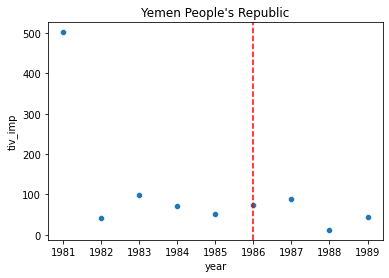

In [44]:
feat = 'tiv_imp'
rand_onset = onsets[np.random.randint(0,len(onsets),1)[0]]
print(bin_onset_effect(sambanis, rand_onset[1], rand_onset[0], feat, 5, threshold=0.1))
display_onset_effect(sambanis, rand_onset[1], rand_onset[0], feat, 5)

In [45]:
onset_date = rand_onset[0]
start = onset_date - np.timedelta64(366*5+1, 'D')
end = onset_date + np.timedelta64(366*4, 'D')

In [46]:
rand_onset

(Timestamp('1986-01-01 00:00:00'), "Yemen People's Republic")

In [47]:
np.datetime64(rand_onset[0])

numpy.datetime64('1986-01-01T00:00:00.000000')

In [48]:
sambanis.loc[(sambanis['country']==rand_onset[1])][['year',feat]]

,year,tiv_imp
6960,1967-01-01,29.0
6961,1968-01-01,13.0
6962,1969-01-01,58.0
6963,1970-01-01,17.0
6964,1971-01-01,49.0
6965,1972-01-01,112.0
6966,1973-01-01,83.0
6967,1974-01-01,68.0
6968,1975-01-01,12.0
6969,1976-01-01,NaN


In [49]:
threshold = 0.1
feat = 'milper'
win = 3
incr = True

sum_var = np.array([bin_onset_effect(sambanis,
                                     ons[1],
                                     ons[0],
                                     feat,
                                     win,
                                     threshold,
                                     incr
                                    ) for ons in onsets])
pos_onsets = [ons for ons in onsets if bin_onset_effect(sambanis, ons[1], ons[0], feat, win, threshold, incr) == (1,1)]
print(sum_var[:,0].sum()/sum_var[:,1].sum())
print(sum_var[:,0].sum()) #positive finding
print(sum_var[:,1].sum()) #entries with available data

0.5591397849462365
52
93


In [50]:
pos_onsets

[(Timestamp('1991-01-01 00:00:00'), 'Algeria'),
 (Timestamp('1955-01-01 00:00:00'), 'Argentina'),
 (Timestamp('1952-01-01 00:00:00'), 'Bolivia'),
 (Timestamp('1972-01-01 00:00:00'), 'Burundi'),
 (Timestamp('1988-01-01 00:00:00'), 'Burundi'),
 (Timestamp('1970-01-01 00:00:00'), 'Cambodia'),
 (Timestamp('1996-01-01 00:00:00'), 'Central African Republic'),
 (Timestamp('1992-01-01 00:00:00'), 'Congo'),
 (Timestamp('1948-01-01 00:00:00'), 'Costa Rica'),
 (Timestamp('1958-01-01 00:00:00'), 'Cuba'),
 (Timestamp('1974-01-01 00:00:00'), 'Cyprus'),
 (Timestamp('1991-01-01 00:00:00'), 'Djibouti'),
 (Timestamp('1979-01-01 00:00:00'), 'El Salvador'),
 (Timestamp('1966-01-01 00:00:00'), 'Guatemala'),
 (Timestamp('1978-01-01 00:00:00'), 'Guatemala'),
 (Timestamp('1998-01-01 00:00:00'), 'Guinea-Bissau'),
 (Timestamp('1991-01-01 00:00:00'), 'Haiti'),
 (Timestamp('1965-01-01 00:00:00'), 'India'),
 (Timestamp('1963-01-01 00:00:00'), 'Indonesia'),
 (Timestamp('1978-01-01 00:00:00'), 'Iran'),
 (Timestamp('

In [51]:
incr_holder = []
for feat in feat_subset:
    dummy = [-1, -1, -1, -1, -1]
    for i, thr in enumerate([0.1, 0.5, 1, 2, 4]):
        tmp = np.array([bin_onset_effect(sambanis, ons[1], ons[0], feat, 3, thr, inc=True) for ons in onsets])
        dummy[i] = tmp[:,0].sum()/tmp[:,1].sum()
    incr_holder.append(dummy)
    
decr_holder = []
for feat in feat_subset:
    dummy = [-1, -1, -1, -1, -1]
    for i, thr in enumerate([0.1, 0.5, 1, 2, 4]):
        tmp = np.array([bin_onset_effect(sambanis, ons[1], ons[0], feat, 3, thr, inc=False) for ons in onsets])
        dummy[i] = tmp[:,0].sum()/tmp[:,1].sum()
    decr_holder.append(dummy)

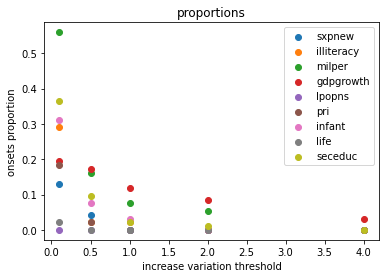

In [52]:
for i in range(len(feat_subset)):
    plt.scatter([0.1, 0.5, 1, 2, 4], incr_holder[i], label=feat_subset[i])
    plt.title("proportions")
plt.xlabel("increase variation threshold")
plt.ylabel("onsets proportion")
plt.legend()
plt.show()

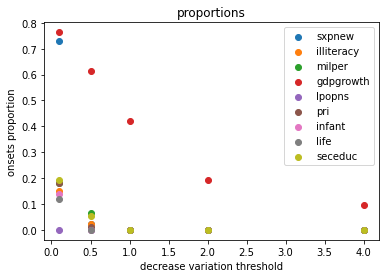

In [53]:
for i in range(len(feat_subset)):
    plt.scatter([0.1, 0.5, 1, 2, 4], decr_holder[i], label=feat_subset[i])
    plt.title("proportions")
plt.xlabel("decrease variation threshold")
plt.ylabel("onsets proportion")
plt.legend()
plt.show()

before 26.333333333333332
after 97.85261646666667
2.715922144303798
(1, 1)


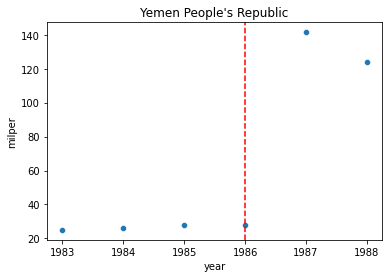

In [54]:
#rand_onset = pos_onsets[np.random.randint(0,len(pos_onsets),1)[0]]
print(bin_onset_effect(sambanis, rand_onset[1], rand_onset[0], 'milper', 3, threshold=0.1, verbose=True))
display_onset_effect(sambanis, rand_onset[1], rand_onset[0], 'milper', 3)

In [55]:
def comp_neighbour_feat(df, country, onset_date, t_win=3, geodata=geodata):
    #get the neighbours
    tmp = list(geodata.loc[geodata["country_name"] == country]["country_border_name"])
    neigh_df = df.loc[df["country"].isin(tmp)]
    
    #restrict the years
    onset_date = np.datetime64(onset_date)
    start = onset_date - np.timedelta64(365*t_win+1, 'D')
    end = onset_date + np.timedelta64(365*(t_win-1), 'D')
    neigh_df = neigh_df.loc[(df["year"] <= end) & (df["year"] >= start)]
    
    neigh_df.drop(columns=['cowcode', 'warstds', 'ptime',
                           'autch98', 'demch98','polch98', 'country_abb',
                           'decade1', 'decade2', 'decade3', 'decade4'],
                  inplace=True)
    
    cols = list(neigh_df.columns[1:])
    cols = cols[1:-5]+cols[-4:]
    #convert to numeric
    neigh_df[cols] = neigh_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)
    
    df_pre = pd.DataFrame()
    df_pos = pd.DataFrame()
    
    #compute the mean of each feature before/after for each feature
    for idx, group in neigh_df.groupby("country"):
        df_pre = pd.concat([df_pre,
                            group.loc[group['year'] < onset_date][cols].apply(np.nanmean, axis=0).rename(idx)],
                            axis=1)
        df_pos = pd.concat([df_pos,
                            group.loc[group['year'] >= onset_date][cols].apply(np.nanmean, axis=0).rename(idx)],
                            axis=1)
    
    return df_pre.T, df_pos.T

In [56]:
print("Country CW onset : ", onsets[10][1])
pre, pos = comp_neighbour_feat(sambanis, onsets[10][1], onsets[10][0])

Country CW onset :  Burundi


/home/toinou/Documents/venvs/pyt3.8/lib/python3.8/site-packages/pandas/core/apply.py:284: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)


In [57]:
pre

,popdense,army85,milper,trade,nmgdp,expgdp,sxpnew,agexp,fuelexp,manuexp,...,mirps1,mirps2,mirps3,sxpsq,pol4sq,proxregc,tiv_imp,tiv_exp,milexp_gdp,milexp_spe
Democratic Republic of the Congo,8.942898,62000.0,38.000000,30.393208,1659.506388,14.330256,0.099897,3.350000,0.230000,6.813333,...,0.0,1.0,0.0,0.010193,81.0,0.006836,67.333333,NaN,0.000000,NaN
Rwanda,151.175501,5000.0,1.000000,24.217873,2139.951253,9.307974,0.159558,3.833529,10.302810,0.028872,...,0.0,1.0,0.0,0.053233,25.0,0.000007,0.000000,NaN,NaN,NaN
Tanzania,15.500320,43000.0,6.666667,72.223316,1166.198893,33.273112,0.158730,30.616537,7.768276,12.736323,...,0.0,1.0,0.0,0.052789,49.0,0.000027,35.500000,NaN,2.366667,NaN


In [58]:
pos

,popdense,army85,milper,trade,nmgdp,expgdp,sxpnew,agexp,fuelexp,manuexp,...,mirps1,mirps2,mirps3,sxpsq,pol4sq,proxregc,tiv_imp,tiv_exp,milexp_gdp,milexp_spe
Democratic Republic of the Congo,9.567129,62000.0,48.5,28.646000,1681.100037,11.739225,0.079682,6.089090,9.115557,19.474289,...,0.0,1.0,0.0,0.006351,81.0,1.525705e-04,10.0,NaN,0.0,NaN
Rwanda,163.822044,5000.0,3.0,25.808986,2148.992188,9.246684,0.158972,4.690706,15.315481,2.315075,...,0.0,1.0,0.0,0.052950,25.0,1.488000e-07,1.0,NaN,1.9,NaN
Tanzania,16.695345,43000.0,11.0,72.173372,1209.155700,33.243810,0.158588,27.423531,9.487990,11.696484,...,0.0,1.0,0.0,0.052817,49.0,5.960000e-07,82.5,NaN,3.8,NaN


In [59]:
#compute the variation and transpose
tmp = (pos[feat_subset]-pre[feat_subset])/pre[feat_subset]
tmp

,sxpnew,illiteracy,milper,gdpgrowth,lpopns,pri,infant,life,seceduc
Democratic Republic of the Congo,-0.202362,0.543531,0.276316,-0.351507,0.004019,0.157895,-0.083916,0.018034,0.421053
Rwanda,-0.003669,0.485207,2.000000,-1.508428,0.005323,0.172414,-0.021082,0.004529,0.000000
Tanzania,-0.000898,0.377065,0.650000,1.248915,0.004531,0.040816,0.432405,0.021553,0.285714


In [69]:
t_win = 5


df_tmp = pd.DataFrame()
df_pre = pd.DataFrame()
df_pos = pd.DataFrame()

for onset in onsets:
    pre, pos = comp_neighbour_feat(sambanis,
                                   onset[1],
                                   onset[0],
                                   t_win=t_win,
                                  )
    """df_tmp = pd.concat([df_tmp,
                        (pos-pre)/pre
                       ]
                      )"""
    df_pre = pd.concat([df_pre,
                        pre
                       ]
                      )
    
    df_pos = pd.concat([df_pos,
                        pos
                       ]
                      )
    
df_tmp = (df_pos-df_pre)/df_pre
df_tmp.head(5)

/home/toinou/Documents/venvs/pyt3.8/lib/python3.8/site-packages/pandas/core/apply.py:284: RuntimeWarning: Mean of empty slice
  results[i] = self.f(v)
/home/toinou/Documents/venvs/pyt3.8/lib/python3.8/site-packages/pandas/core/apply.py:201: RuntimeWarning: Mean of empty slice
  r = self.f(Series([], dtype=np.float64))
/home/toinou/Documents/venvs/pyt3.8/lib/python3.8/site-packages/pandas/core/apply.py:209: RuntimeWarning: Mean of empty slice
  r = self.f(Series([], dtype=np.float64))


,popdense,army85,milper,trade,nmgdp,expgdp,sxpnew,agexp,fuelexp,manuexp,...,mirps1,mirps2,mirps3,sxpsq,pol4sq,proxregc,tiv_imp,tiv_exp,milexp_gdp,milexp_spe
China,0.066153,0.000000,0.000000,0.197609,0.041307,0.120882,-0.001609,-0.001609,-0.000245,0.003062,...,NaN,0.000000,NaN,-0.002042,-0.196721,-9.987805e-01,0.537356,0.299287,NaN,NaN
Iran,0.157899,0.000000,0.381303,-0.378198,0.032250,-0.378724,-0.436459,1.250760,-0.204526,2.875409,...,inf,-0.360775,inf,-0.576600,-0.231892,3.222646e+10,-0.686303,-1.000000,-0.140271,NaN
Pakistan,0.147071,0.000000,0.074627,0.067943,-0.147478,-0.070559,-0.064093,-0.249332,2.402368,-0.026196,...,16.432767,-1.000000,-1.0,-0.120595,-0.191545,-2.869128e-01,1.887414,NaN,-0.075000,NaN
Libya,-0.000349,-0.005627,-0.005616,0.000099,0.000132,0.000187,0.000433,0.001244,0.000285,-0.000396,...,NaN,0.000000,NaN,0.000589,0.000000,-9.987840e-01,-0.171429,NaN,0.314286,NaN
Mali,-0.935787,-0.875709,-0.946472,-0.000122,-0.002290,0.001792,-0.002354,0.258533,-0.481074,-0.439191,...,-1.000000,0.570533,-1.0,-0.007794,-0.110125,-8.552427e-01,1.333333,NaN,0.009259,NaN


In [61]:
feat_subset

['sxpnew',
 'illiteracy',
 'milper',
 'gdpgrowth',
 'lpopns',
 'pri',
 'infant',
 'life',
 'seceduc']

In [70]:
feat = 'infant'
thr = 1

print(len(df_tmp.loc[df_tmp[feat] > thr]))
print(len(df_tmp.loc[df_tmp[feat] < -thr]))
print(df_tmp[feat].isnull().sum())
tot = len(df_tmp[feat]) - df_tmp[feat].isnull().sum()
print(tot)
print(len(df_tmp.loc[df_tmp[feat] > thr])/tot)
print(len(df_tmp.loc[df_tmp[feat] <- thr])/tot)

14
0
31
380
0.03684210526315789
0.0


In [82]:
np.nanmean(df_pre['life'].drop_duplicates())

54.810534708456885

In [83]:
np.nanmean(df_pos['life'].drop_duplicates())

55.044982676483016

In [81]:
df_tmp.index.drop_duplicates()

Index(['China', 'Iran', 'Pakistan', 'Libya', 'Mali', 'Mauritania', 'Morocco',
       'Niger', 'Tunisia', 'Congo',
       ...
       'Ireland', 'Belarus', 'Estonia', 'Finland', 'Kazakhstan', 'Latvia',
       'Lithuania', 'Norway', 'Poland', 'Oman'],
      dtype='object', length=114)